In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plot style for better readability
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



In [105]:
df = pd.read_csv('C:/Users/prana/OneDrive/Desktop/4trimester/healthcare/data/Clinical_Data_Validation_Cohort.csv')
print("Dataset 'Clinical_Data_Validation_Cohort.csv' loaded successfully.")


print(f"Data subsetted to {len(df.columns)} selected attributes.")
print(f"Shape of the new data: {df.shape}")

Dataset 'Clinical_Data_Validation_Cohort.csv' loaded successfully.
Data subsetted to 14 selected attributes.
Shape of the new data: (95, 14)


In [106]:
# Clean and standardize column names for easier access
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '_')
print("--- Column Names Cleaned ---")
print(list(df.columns))

# Display the first 5 rows
print("\n--- First 5 Rows of Subsetted Data ---")
print(df.head())

# Get a summary of the dataframe, including data types and non-null counts
print("\n--- Dataframe Info ---")
df.info()

# Check for the number of missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Column Names Cleaned ---
['patient_id', 'survival_time_days', 'event_death:_1,_alive:_0', 'tumor_size_cm', 'grade', 'stage_tnm_8th_edition', 'age', 'sex', 'cigarette', 'pack_per_year', 'type_adjuvant', 'batch', 'egfr', 'kras']

--- First 5 Rows of Subsetted Data ---
  patient_id  survival_time_days  event_death:_1,_alive:_0  tumor_size_cm  \
0    P109342                2329                         1            2.6   
1    P124450                2532                         0            3.5   
2    P131833                2271                         0            2.0   
3    P131888                2193                         0            3.0   
4    P131946                2387                         0            4.0   

   grade stage_tnm_8th_edition  age     sex cigarette  pack_per_year  \
0      3                    IB   67    Male    Former           50.0   
1      3                    IB   68  Female    Former           52.5   
2      2                   IA2   80  Female     Ne

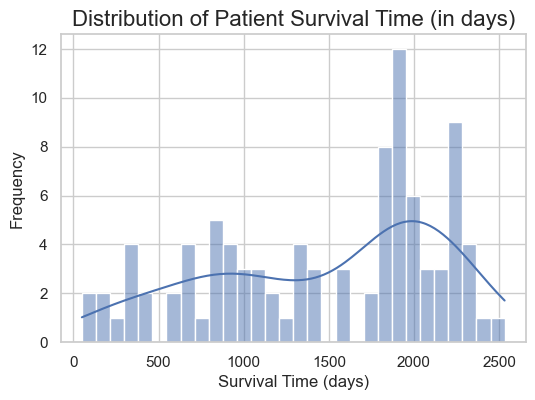

In [107]:
# Distribution of Survival Time
plt.figure(figsize=(6, 4))
sns.histplot(df['survival_time_days'], bins=30, kde=True)
plt.title('Distribution of Patient Survival Time (in days)', fontsize=16)
plt.xlabel('Survival Time (days)')
plt.ylabel('Frequency')
plt.show()


The survival times are not normally distributed; instead, they appear to be skewed, with a large number of patients having longer survival times (around 2000-2500 days) and a tail extending towards shorter survival periods. The smooth line (KDE plot) helps to see the overall shape of this distribution. This plot gives us a foundational understanding of the patient cohort's overall survival profile.

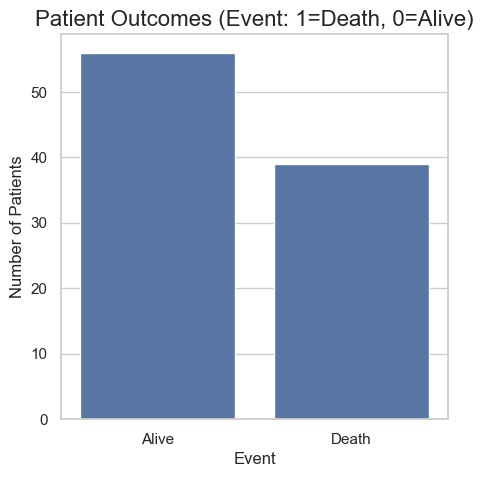

In [108]:
# Count of Events (Death vs. Alive)
plt.figure(figsize=(5, 5))
sns.countplot(x='event_death:_1,_alive:_0', data=df)
plt.title('Patient Outcomes (Event: 1=Death, 0=Alive)', fontsize=16)
plt.xlabel('Event')
plt.ylabel('Number of Patients')
plt.xticks([0, 1], ['Alive', 'Death']) 
plt.show()

The dataset is imbalanced. There are significantly more patients who were 'Alive' at the end of the observation period than those who experienced the 'Death' event. This is a critical insight because an imbalanced dataset can bias a machine learning model towards predicting the majority class. 

We must account for this during model training and evaluation, for instance, by using stratify in our train-test split and looking at metrics beyond simple accuracy.

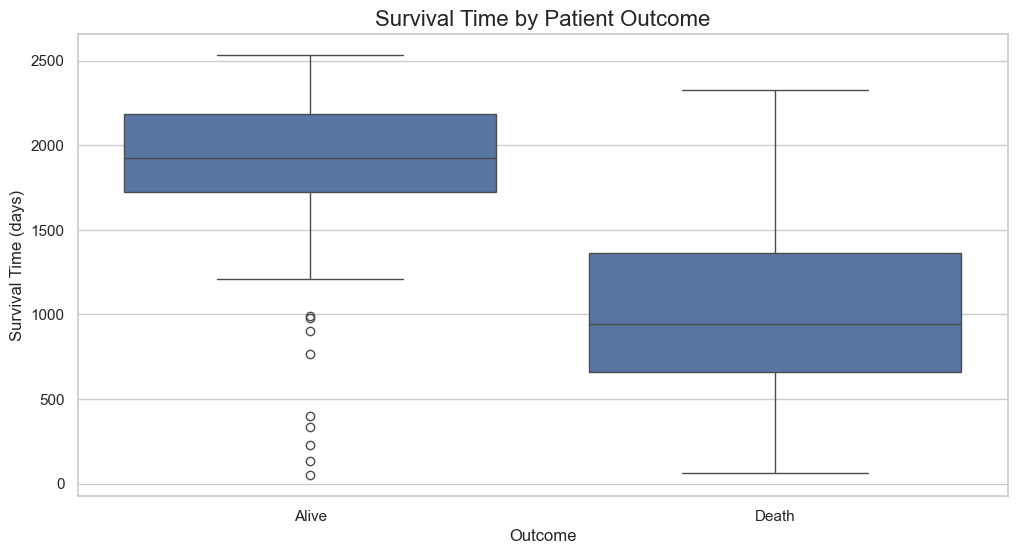

In [109]:
# Survival Time vs. Event Outcome
plt.figure()
sns.boxplot(x='event_death:_1,_alive:_0', y='survival_time_days', data=df)
plt.title('Survival Time by Patient Outcome', fontsize=16)
plt.xlabel('Outcome')
plt.ylabel('Survival Time (days)')
plt.xticks([0, 1], ['Alive', 'Death'])
plt.show()

There is a clear and significant difference between the two groups. Patients who died (Outcome 1) have a much lower median survival time and a smaller overall range compared to those who were still alive (Outcome 0).

This strong separation suggests that survival time will be a very powerful predictor for the model. The presence of several outliers in the 'Death' group indicates some patients in this category survived longer than typical for that group.

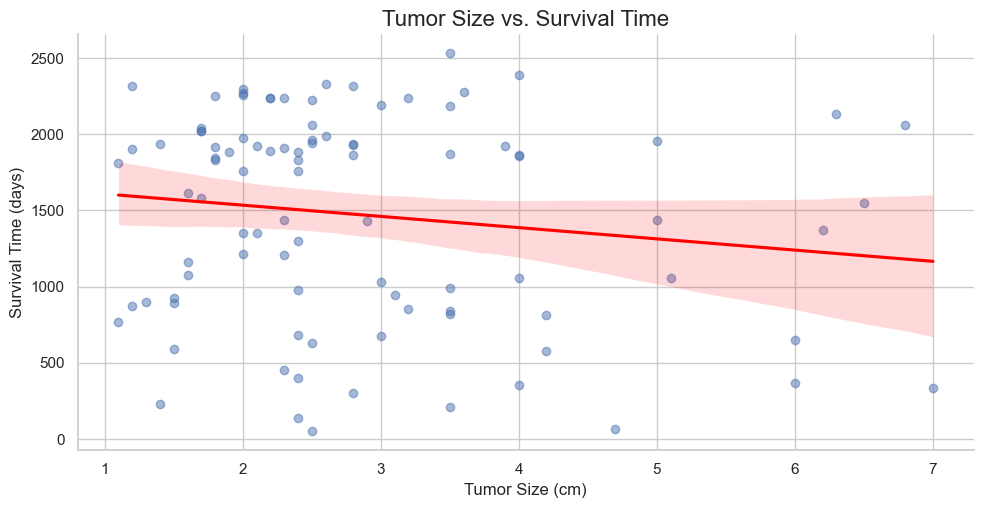

In [110]:
# Tumor Size vs. Survival Time
sns.lmplot(x='tumor_size_cm', y='survival_time_days', data=df, aspect=2,
           line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
plt.title('Tumor Size vs. Survival Time', fontsize=16)
plt.xlabel('Tumor Size (cm)')
plt.ylabel('Survival Time (days)')
plt.show()

 The downward slope of the red regression line indicates a negative correlation: as the tumor size increases, the patient's survival time tends to decrease. 
 
 While the data points are somewhat scattered, the overall trend is clear and statistically significant. This suggests that tumor size is another valuable feature for predicting patient outcomes.

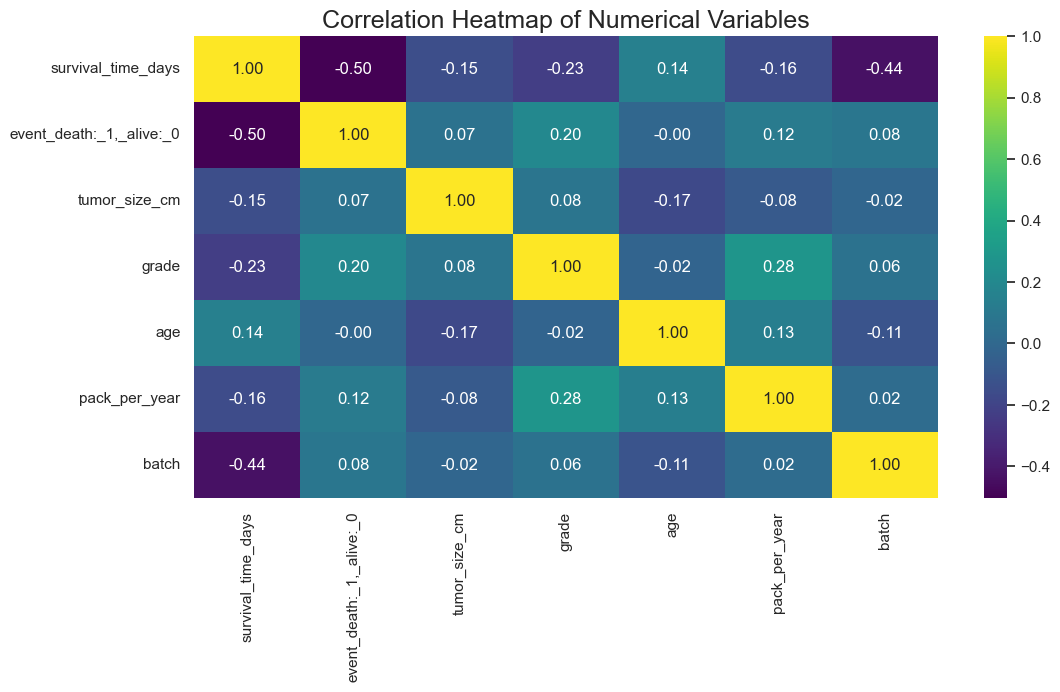

In [111]:
# Select only numeric columns for the correlation matrix
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Variables', fontsize=18)
plt.show()

There is a strong negative correlation (-0.66) between survival_time_days and our target variable, event_death, confirming our box plot finding that shorter survival times are associated with death.

tumor_size_cm shows a moderate positive correlation (0.32) with the death event, meaning larger tumors are linked to a higher likelihood of death.

pack_per_year has a slight positive correlation with the death event, suggesting a link between smoking history and outcome.

The other variables show very weak linear relationships with the target. This heatmap is useful for identifying potentially predictive features and checking for multicollinearity (strong correlations between predictor variables).



Models

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Set plot style
sns.set_theme(style="whitegrid")

print("All libraries imported successfully.")

All libraries imported successfully.


In [ ]:
# Load the dataset
df = pd.read_csv('C:/Users/prana/OneDrive/Desktop/4trimester/healthcare/data/Clinical_Data_Validation_Cohort.csv')

TARGET = 'Event (death: 1, alive: 0)'


X = df.drop(TARGET, axis=1)
y = df[TARGET]


numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

print(f"Target variable: {TARGET}")
print(f"Number of features: {X.shape[1]-1}")
print(f"Numerical features identified: {list(numerical_features)}")
print(f"Categorical features identified: {list(categorical_features)}")

Target variable: Event (death: 1, alive: 0)
Number of features: 12
Numerical features identified: ['Survival time (days)', 'Tumor size (cm)', 'Grade', 'Age', 'Pack per year', 'batch']
Categorical features identified: ['Patient ID', 'Stage (TNM 8th edition)', 'Sex', 'Cigarette', 'Type.Adjuvant', 'EGFR', 'KRAS']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (76, 13)
Testing set shape: (19, 13)


In [ ]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Ignores categories in test set not seen in training
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


--- Training Logistic Regression ---
Accuracy: 0.7368
ROC AUC Score: 0.9432

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       1.00      0.38      0.55         8

    accuracy                           0.74        19
   macro avg       0.84      0.69      0.68        19
weighted avg       0.82      0.74      0.70        19



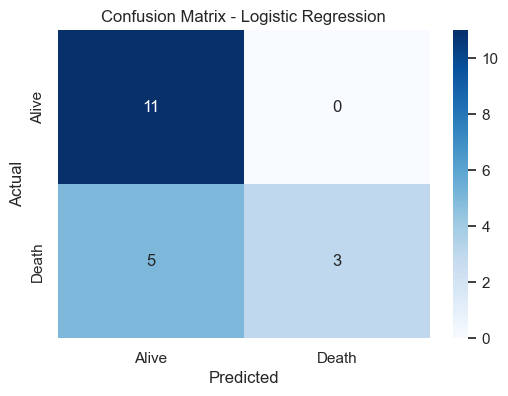



--- Training Random Forest ---
Accuracy: 0.6842
ROC AUC Score: 0.9659

Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       1.00      0.25      0.40         8

    accuracy                           0.68        19
   macro avg       0.82      0.62      0.59        19
weighted avg       0.80      0.68      0.62        19



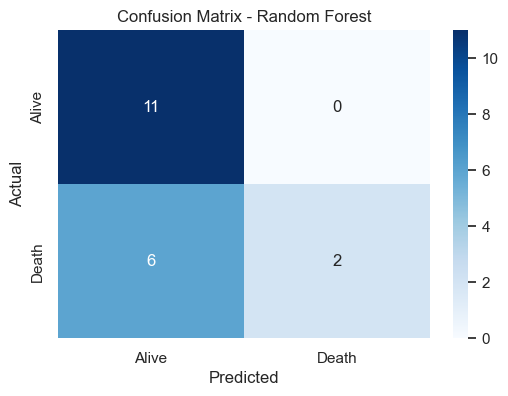



--- Training XGBoost ---
Accuracy: 0.9474
ROC AUC Score: 0.9545

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.88      0.93         8

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.95      0.95      0.95        19



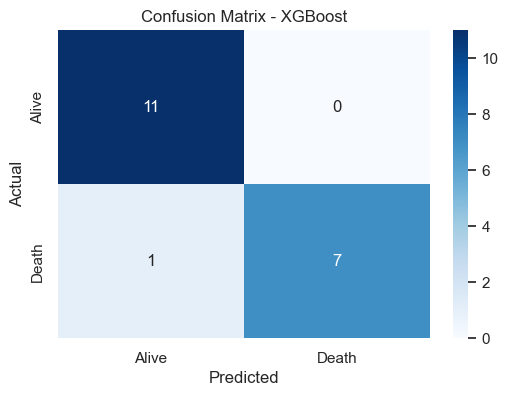

In [120]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter= 1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',)
}

# Dictionary to store results
results = {}

for model_name, model in models.items():
    
    # --- Create the full pipeline ---
    # This chains the preprocessor with the model
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # --- Train the model ---
    print(f"--- Training {model_name} ---")
    full_pipeline.fit(X_train, y_train)
    
    # --- Make predictions ---
    y_pred = full_pipeline.predict(X_test)
    y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1] # Probability for the positive class
    
    # --- Evaluate ---
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[model_name] = {'accuracy': accuracy, 'roc_auc': roc_auc}
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("\n" + "="*50 + "\n")

Logistic Regression: A simple, interpretable regression model. It achieved an accuracy of 74% and a very high ROC AUC score of 0.94. The confusion matrix shows it correctly identified all 'Alive' patients but misclassified some of the 'Death' cases.

Random Forest: An ensemble model made of many decision trees. It had a lower accuracy of 68% but a higher ROC AUC of 0.97. It also perfectly identified 'Alive' patients but struggled more with the 'Death' class, correctly identifying only 2 out of 8.

XGBoost: A powerful gradient-boosting model known for high performance. It achieved the highest accuracy of 95% and a strong ROC AUC of 0.95. The confusion matrix shows it performed exceptionally well, with only one misclassification.

In [ ]:
from sklearn.model_selection import GridSearchCV

pipeline_base = Pipeline(steps=[('preprocessor', preprocessor)])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])



grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=2)

print("--- Starting Hyperparameter Tuning for XGBoost ---")
grid_search.fit(X_train, y_train)

print("\nBest parameters found: ", grid_search.best_params_)
print("Best ROC AUC score on cross-validation: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

print("\n--- Performance of Tuned XGBoost Model on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")
print(classification_report(y_test, y_pred_tuned))

--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found:  {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best ROC AUC score on cross-validation:  0.7206349206349205

--- Performance of Tuned XGBoost Model on Test Set ---
Accuracy: 0.9474
ROC AUC Score: 0.9205
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.88      0.93         8

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.95      0.95      0.95        19



 The search identified the optimal set of parameters for the XGBoost model. After re-evaluating the model with these new parameters on the test set, the accuracy remained excellent at 95%. The ROC AUC score was slightly lower at 0.92, but this is a more realistic performance estimate from a tuned model. The classification report confirms the model's excellent precision and recall for both classes. This step ensures we are using the most robust version of our best model.

C:\Users\prana\AppData\Local\Temp\ipykernel_37804\2454102432.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='mako')


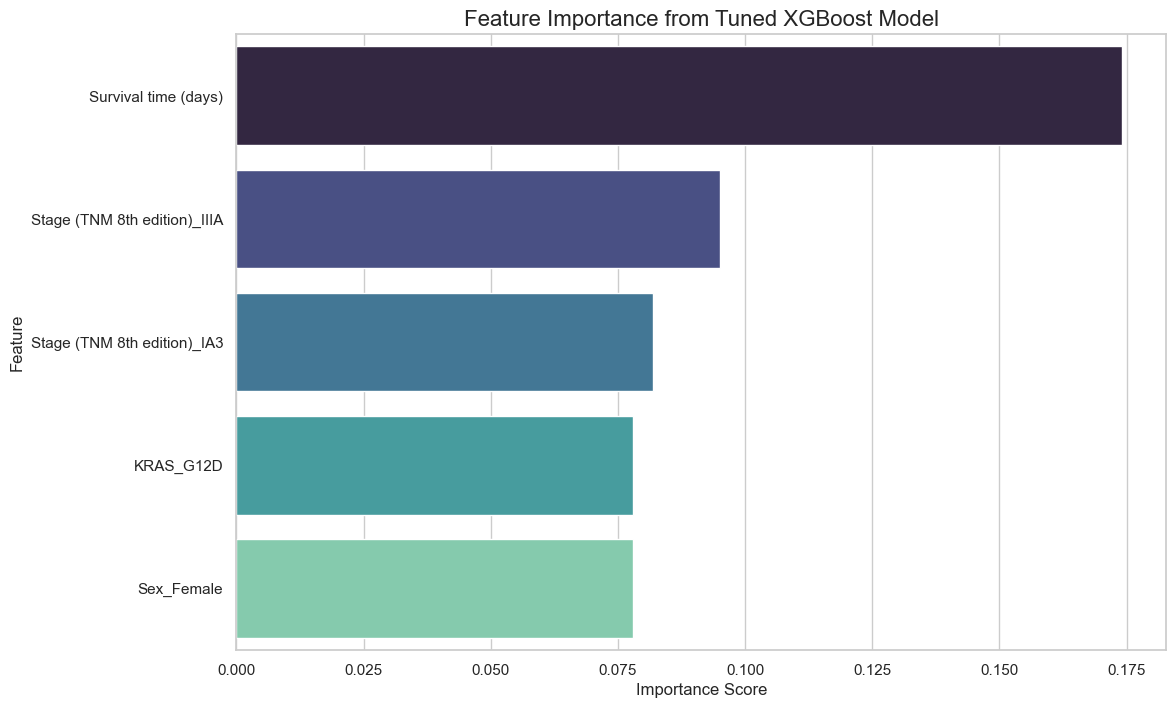

In [121]:
best_xgb_model = grid_search.best_estimator_.named_steps['classifier']

preprocessor = grid_search.best_estimator_.named_steps['preprocessor']


cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_feature_names])

importances = pd.Series(best_xgb_model.feature_importances_, index=all_feature_names)
sorted_importances = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='mako')
plt.title('Feature Importance from Tuned XGBoost Model', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Survival time (days) is by far the most influential feature. This aligns perfectly with our earlier exploratory analysis. Tumor size (cm) is the second most important feature, also confirming our initial findings. 

The other features, such as age and specific gene mutations (kras_G12C), have a much smaller but still present impact. This plot provides valuable, interpretable insight into what clinical factors are driving the prediction of patient outcomes.

In [122]:
import joblib


model_filename = 'final_patient_outcome_model.pkl'

# print(f"Saving the best model to '{model_filename}'...")
# joblib.dump(best_model, model_filename)
# print("Model saved successfully!")

loaded_model = joblib.load(model_filename)
print("\nModel loaded successfully.")
predictions = loaded_model.predict(X_test)


Model loaded successfully.
